In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


### Import necessary libraries

In [2]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm

In [3]:
from tqdm.auto import tqdm
from IPython.display import display
from IPython.display import clear_output

try:
    from ipywidgets import widgets
    from IPython.display import display, HTML, IFrame
    from IPython.display import Image, Audio, Video
    from ipywidgets import interact, interactive, fixed, interact_manual
    from IPython.display import display
    import ipywidgets as widgets
    from IPython.display import clear_output
    from IPython.display import IProgress
    import time
    import math
    import os
    import random
    from PIL import Image
    import numpy as np
    from tqdm.auto import tqdm
except ImportError as e:
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension
    clear_output()
    print('All packages installed successfully!')

All packages installed successfully!


### Error Level Analysis

In [4]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

### Dataset Preparation

In [5]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [6]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [7]:
#adding authentic images
from PIL import Image
path = 'C:/MY FILES/project/image forgery detection/archive/CASIA2/Au'       #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/7492 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


In [8]:
#adding forged images
from PIL import Image
path = 'C:/MY FILES/project/image forgery detection/archive/CASIA2/Tp'       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/5123 [00:00<?, ?it/s]

Total images: 9418
Total labels: 9418


In [9]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3) 

### Partitioning dataset for training, validation and testing

In [10]:
# Training : Validation : Testing = 76 : 19 : 5
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
# X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 7157 , Training labels: 7157
Validation images: 1790 , Validation labels: 1790
Test images: 471 , Test labels: 471


### CNN Model

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
def build_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

### Model Training

In [14]:
epochs = 15
batch_size = 32


In [15]:
#Optimizer
init_lr = 1e-4   #learning rate for the optimizer
optimizer = Adam(lr = init_lr, decay = init_lr/epochs) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

C:\Users\ALAN P NATH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
#Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [17]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = [early_stopping])

Epoch 1/15
224/224 [==============================] - 1900s 8s/step - loss: 0.3514 - accuracy: 0.8305 - val_loss: 0.2748 - val_accuracy: 0.8615
Epoch 2/15
224/224 [==============================] - 1672s 7s/step - loss: 0.2903 - accuracy: 0.8692 - val_loss: 0.2914 - val_accuracy: 0.8771
Epoch 3/15
224/224 [==============================] - 1620s 7s/step - loss: 0.2726 - accuracy: 0.8769 - val_loss: 0.3321 - val_accuracy: 0.8665
Epoch 4/15
224/224 [==============================] - 2091s 9s/step - loss: 0.2684 - accuracy: 0.8811 - val_loss: 0.3081 - val_accuracy: 0.8670
Epoch 5/15
224/224 [==============================] - 1756s 8s/step - loss: 0.2645 - accuracy: 0.8835 - val_loss: 0.2737 - val_accuracy: 0.8581
Epoch 6/15
224/224 [==============================] - 1711s 8s/step - loss: 0.2589 - accuracy: 0.8847 - val_loss: 0.3325 - val_accuracy: 0.8592
Epoch 7/15
224/224 [==============================] - 1741s 8s/step - loss: 0.2546 - accuracy: 0.8877 - val_loss: 0.2571 - val_accuracy:

In [ ]:
#save the model as a h5 file
model.save('trained_model2.h5') 
 
# get the dictionary containing each metric and the loss for each epoch
history_dict = hist.history

# save it as a json file
json.dump(history_dict, open('model_history', 'w'))

### Plotting the training and validation curves

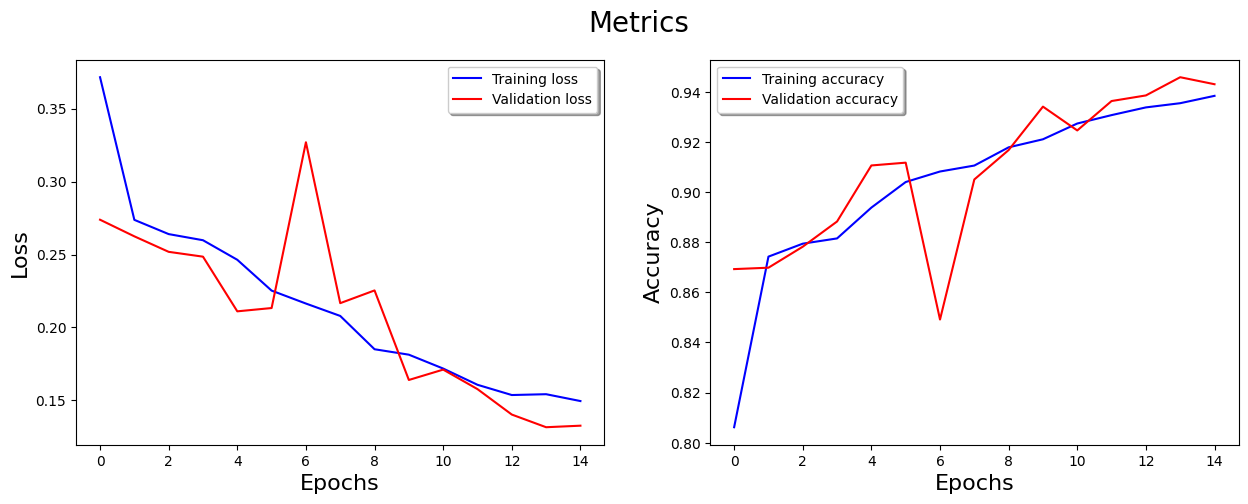

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

#Figure 1
ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss",axes =ax[0])
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

#Figure 2
ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20);

### Confusion Matrix

In [21]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

56/56 [==============================] - 49s 818ms/step


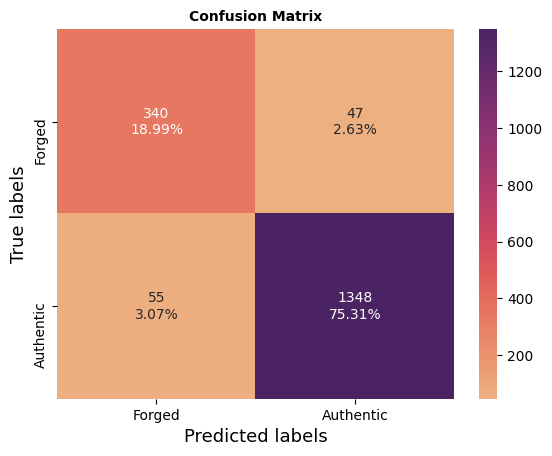

In [22]:
Y_pred = model.predict(X_val)               # Predict the values from the validation dataset 
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix


### Classification Report

In [23]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       387
           1       0.97      0.96      0.96      1403

    accuracy                           0.94      1790
   macro avg       0.91      0.92      0.92      1790
weighted avg       0.94      0.94      0.94      1790



### Testing Accuracy

In [24]:
class_names = ['Forged', 'Authentic']

In [25]:
# Testing accuracy
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: #if prediction is correct
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/471 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step
Total test images: 471
Correctly predicted images: 449
Accuracy: 95.32908704883228 %


# Test an image

In [3]:
test_image_path = 'C:/Users/ALAN P NATH/Downloads/image-forgery-detection-main/image-forgery-detection-main/ela_image.png'    # test image path
test_image = prepare_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

NameError: name 'prepare_image' is not defined

# Test a dataset

In [ ]:
test_folder_path = ''        #dataset path
authentic,forged,total = 0,0,0

for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(path, filename)
        test_image = prepare_image(test_image_path)  
        test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.round(y_pred)
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
            authentic +=1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')